# Implementación de una red LSTM sencilla para practicar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Intentamos leer el archivo, tal y como nos viene nos genera errores que debemos solventar con la r y luego especificando el encoding
df = pd.read_csv(r"DatosHistoricos_663461_A011Z65QRIO1.csv", sep = ";", encoding='latin-1')
df.head()

,Máximo,Mínimo,Media,Fecha máximo,Fecha mínimo,fecha
0,585,"483,28",545,2010-01-01 22:30:00,2010-01-01 00:00:00,2010-01-01 00:00:00
1,585,"532,12",556,2010-01-02 00:00:00,2010-01-02 21:45:00,2010-01-02 00:00:00
2,528,"450,8",498,2010-01-03 00:00:00,2010-01-03 23:30:00,2010-01-03 00:00:00
3,451,386,408,2010-01-04 00:00:00,2010-01-04 19:00:00,2010-01-04 00:00:00
4,418,386,405,2010-01-05 08:15:00,2010-01-05 00:00:00,2010-01-05 00:00:00


In [3]:
df.columns

Index(['Máximo', 'Mínimo            ', 'Media           ',
       'Fecha máximo                    ', 'Fecha mínimo', 'fecha         '],
      dtype='object')

In [4]:
df =df.drop(["Máximo",'Mínimo            ','Fecha máximo                    ','Fecha mínimo'], axis =1)

In [5]:
#modificamos los nombres de las columnas y eliminamos las que no necesitasmos
df.columns = ["Media","Fecha"]

In [6]:
#Convertimos a un formato de datatime la columna fecha
from datetime import datetime
df["Fecha"]= pd.to_datetime(df["Fecha"])

In [7]:
df =df.set_index("Fecha", append=False, inplace=False, verify_integrity=False)

In [8]:
#Debemos preprocesar los datos para 

In [9]:
#import plotly.express as px
#fig = px.line(df, x=df.index, y="Media",template = "plotly_dark",
#              title="Caudal medio a su paso por Zaragoza")
#fig.show()

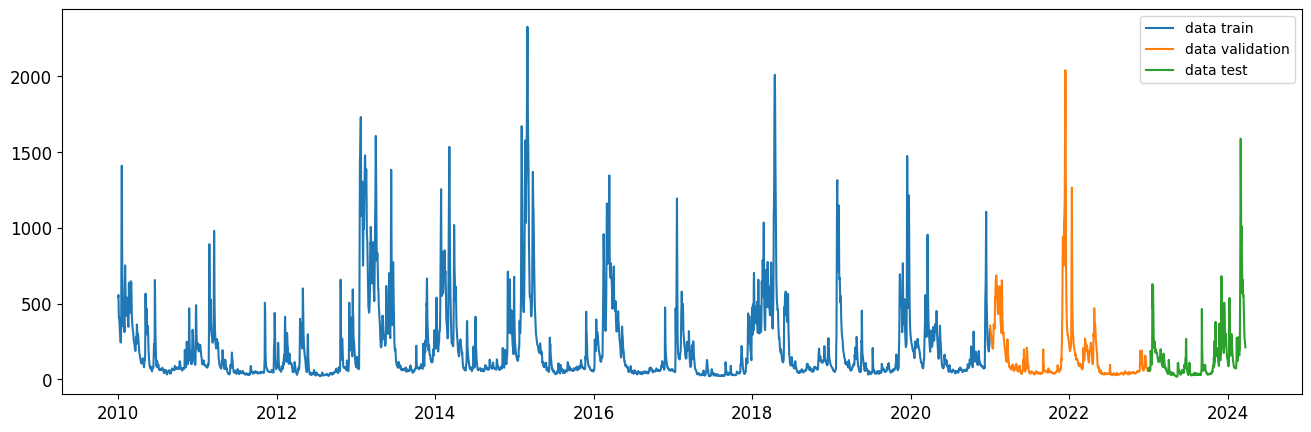

In [10]:
#Dibujamos la división para verificar que se encuentran de manera consecutiva
#Observamos que los parametros de tiempo han sido correctos
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(df[:"2020"], label="data train")
ax.plot(df["2021":"2022"], label="data validation")
ax.plot(df["2023":], label="data test")
plt.legend();

In [11]:
#Dividimos los datos
trainingSet = df[:"2020"]
validationSet = df["2021":"2023"]
testSet = df["2024":]

In [12]:
# Normaliza los datos
scaler = MinMaxScaler(feature_range=(0, 1))
trainingSetScaled = scaler.fit_transform(trainingSet[["Media"]])
validationSetScaled = scaler.fit_transform(validationSet[["Media"]])
testSetScaled = scaler.fit_transform(testSet[["Media"]])

In [13]:
#Creamos una función bucle para preparar el dataset con los datos.

def create_sequences(array, input_length, output_length):
    X = [] #Lista de listas, cada lísta interior va ser definido por Steps
    y = [] #Lista con las salidas (debemos definir cuantas salidas queremos) del conjunto de 30 datos
    fils, cols = array.shape #multivariado
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    return np.array(X), np.array(y)

#Dejar claro que X_train es forma matriz, y_train es forma array

In [14]:
#El entrenamiento de nuestra red neuronal recurrente va ser alimentado con bloques de datos
# Nosotros debemos especificar el tamaño de paquetes de datos de entrada y el tamaño de paquetes de salida en cada iteración
input_length =30 #Vamos a trabajar con 30 días de datos de entrada
output_length = 5
#Preparamos los datos de entrenamiento del modelo
X_train, y_train = create_sequences(trainingSetScaled,input_length,output_length )
#Preparamos los datos de validacion del modelo
X_valid, y_valid = create_sequences(validationSetScaled,input_length,output_length )
#Preparamos los datos de test del modelo
X_test, y_test = create_sequences(testSetScaled,input_length,output_length )

In [15]:
#Debemos añadir una dimensión a el X_train, es necesario para trabajar con Keras
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #Es una matrizX_train en dos dimensiones que tenemos que pasarla a 3 dimensiones
X_valid = np.reshape(X_valid,(X_valid.shape[0],X_valid.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [16]:
#Parametros para la red neurona 
na = 20
input_shape =(X_train.shape[1],X_train.shape[2])

# Red SIMPLE RNN

Red SIMPLE RNN que cada 30 días anteriores de entrada, nos predice 10 días

In [17]:
RNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(output_length)
])

In [18]:
#Compilación de la red
RNN.compile(loss="mse", optimizer="rmsprop")
#entrenamiento y validación
historyRNN = RNN.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
125/125 [==============================] - 4s 15ms/step - loss: 0.0090 - val_loss: 0.0040
Epoch 2/20
125/125 [==============================] - 2s 12ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 3/20
125/125 [==============================] - 2s 14ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 4/20
125/125 [==============================] - 2s 13ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 5/20
125/125 [==============================] - 2s 13ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 6/20
125/125 [==============================] - 2s 14ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 7/20
125/125 [==============================] - 2s 13ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 8/20
125/125 [==============================] - 2s 12ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 9/20
125/125 [==============================] - 2s 12ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 10/20
125/125 [==============================] - 2s 13ms/step - loss: 0.0033 - val_lo

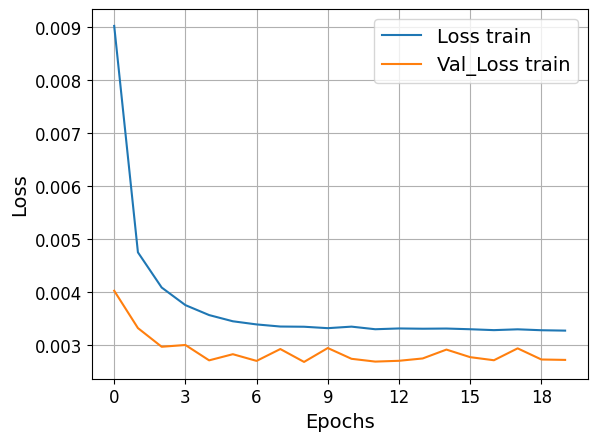

In [19]:
# Graficamos los resultados de modelo 
plt.plot(historyRNN.history["loss"],label="Loss train")
plt.plot(historyRNN.history["val_loss"],label="Val_Loss train")
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)      

In [20]:
realidad = scaler.inverse_transform(testSetScaled)

In [21]:
RNNpred = RNN.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [22]:
RNNpred = scaler.inverse_transform(RNNpred)

In [23]:
realidad = realidad.reshape(-1)

In [24]:
realidad= realidad[input_length-1:-6]

In [25]:
len(RNNpred)

48

In [26]:
RNNpred = pd.DataFrame(RNNpred)
realidad = pd.DataFrame(realidad)
RNNpred = RNNpred.astype(float)
realidad = realidad.astype(float)

In [27]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score,mean_absolute_percentage_error
def metricas(y_test, y_pred):
    mse_list = []
    rmse_list = []
    mae_list = []
    mape_list = []
    output_length = range(y_pred.shape[1])
    for i in output_length:
        test_mse = mean_squared_error(y_test, y_pred[i])
        test_rmse = np.sqrt(test_mse)  # RMSE es la raíz cuadrada del MSE
        test_mae = mean_absolute_error(y_test, y_pred[i])
        test_mape = mean_absolute_percentage_error(y_test, y_pred[i])
        mse_list.append(test_mse)
        rmse_list.append(test_rmse)
        mae_list.append(test_mae)
        mape_list.append(test_mape)
        
        print(f"Predicción día {i+1}")
        print(f"Testing RNN MSE: {test_mse:.4f}")
        print(f"Testing RNN RMSE: {test_rmse:.4f}")
        print(f"Testing RNN MAE: {test_mae:.4f}")
        print(f"Testing RNN MAPE: {test_mape:.4f}%")  # Multiplicamos por 100 para obtener el porcentaje
    return mse_list, rmse_list, mae_list, mape_list


In [28]:
mse_list, rmse_list, mae_list, mape_list= metricas(realidad,RNNpred)

Predicción día 1
Testing RNN MSE: 3550.2810
Testing RNN RMSE: 59.5842
Testing RNN MAE: 35.2971
Testing RNN MAPE: 0.0962%
Predicción día 2
Testing RNN MSE: 4485.0175
Testing RNN RMSE: 66.9703
Testing RNN MAE: 40.3665
Testing RNN MAPE: 0.1293%
Predicción día 3
Testing RNN MSE: 16653.9337
Testing RNN RMSE: 129.0501
Testing RNN MAE: 79.6084
Testing RNN MAPE: 0.2277%
Predicción día 4
Testing RNN MSE: 27804.0825
Testing RNN RMSE: 166.7456
Testing RNN MAE: 104.0329
Testing RNN MAPE: 0.2712%
Predicción día 5
Testing RNN MSE: 21971.5327
Testing RNN RMSE: 148.2280
Testing RNN MAE: 84.7418
Testing RNN MAPE: 0.2081%


In [29]:
def graficar_metricas(dias, mse_list, rmse_list, mae_list, mape_list):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # Dos subplots verticales
    
    # Primer subplot para MSE y MAPE
    ax1.plot(dias, mse_list, 'b-', label='MSE')
    ax1.set_xlabel('Días')
    ax1.set_ylabel('MSE')
    ax1.legend(loc='upper left')
    
    ax1_2 = ax1.twinx()
    ax1_2.plot(dias, mape_list, 'm-', label='MAPE')
    ax1_2.set_ylabel('MAPE (%)')
    ax1_2.legend(loc='upper right')
    
    # Segundo subplot para RMSE y MAE
    ax2.plot(dias, rmse_list, 'r-', label='RMSE')
    ax2.set_xlabel('Días')
    ax2.set_ylabel('RMSE')
    ax2.legend(loc='upper left')
    
    ax2_2 = ax2.twinx()
    ax2_2.plot(dias, mae_list, 'g-', label='MAE')
    ax2_2.set_ylabel('MAE')
    ax2_2.legend(loc='upper right')
    
    # Título general
    fig.suptitle('Métricas de predicción por día')
    
    # Ajustar el espacio entre subplots
    plt.tight_layout()
    
    # Mostrar la gráfica
    plt.show()


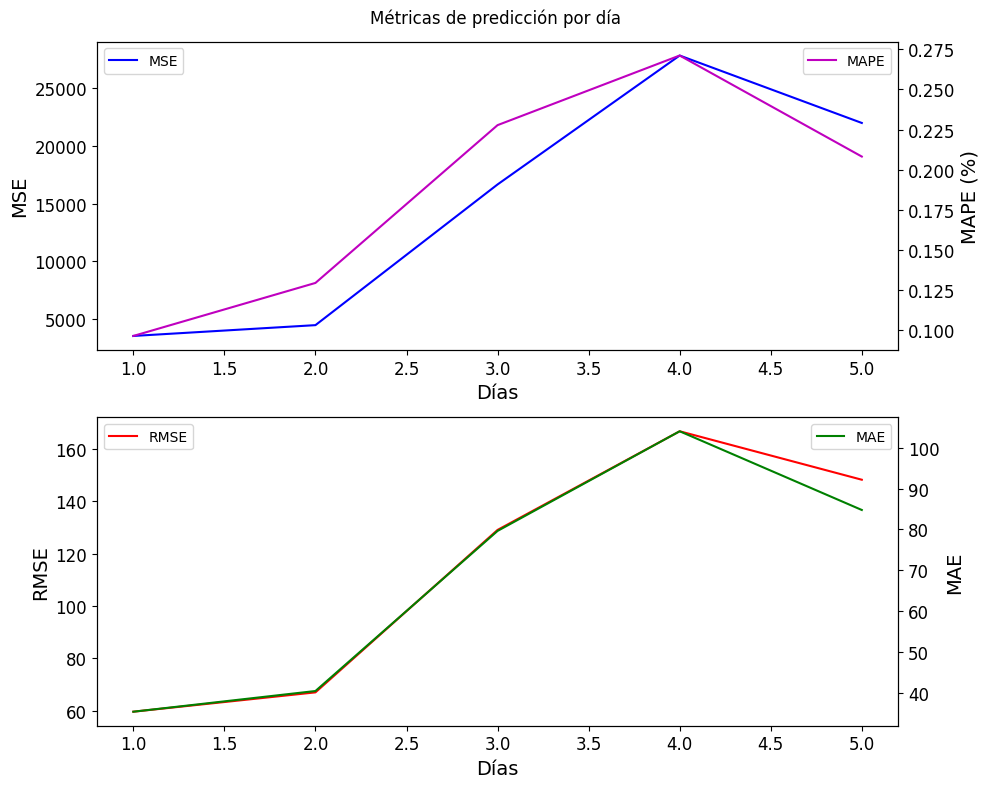

In [30]:
# Definir los días
dias = list(range(1, len(mse_list) + 1))

# Graficar las métricas
graficar_metricas(dias, mse_list, rmse_list, mae_list, mape_list)

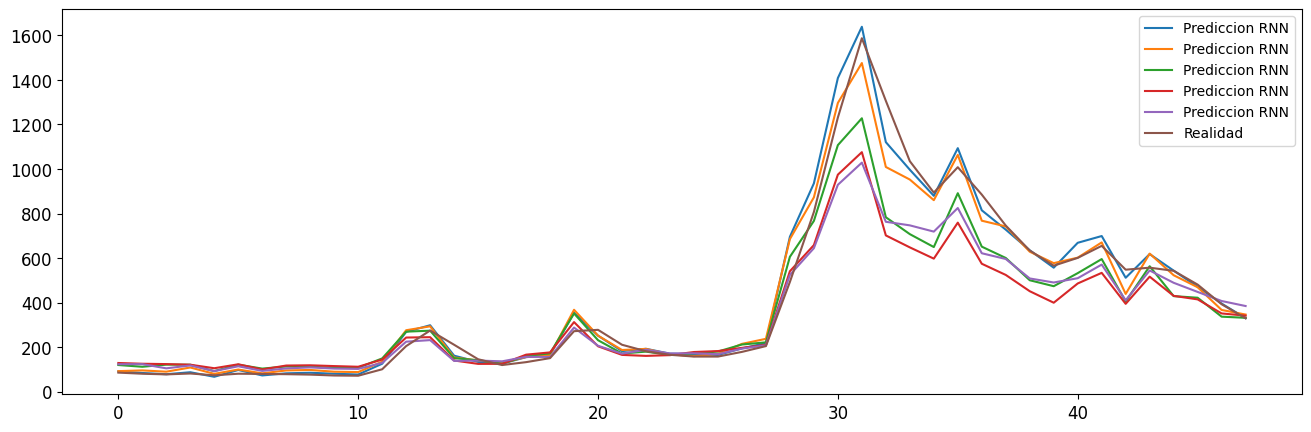

In [31]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(RNNpred, label="Prediccion RNN")
ax.plot(realidad , label="Realidad")# cada 30 días, nos predice 1 salida (0 al 29, empezamos en el día 29)
plt.legend();

In [32]:
n_steps = 30
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")
#save_fig("time_series_plot")
plt.show()

In [33]:
n_steps = 30
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[-20, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[-20, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[-20, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


In [34]:
RNNpred = RNN.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [35]:
RNNpred.shape[0]

48

In [36]:
RNNpred = RNNpred.reshape(RNNpred.shape[0],RNNpred.shape[1],1)

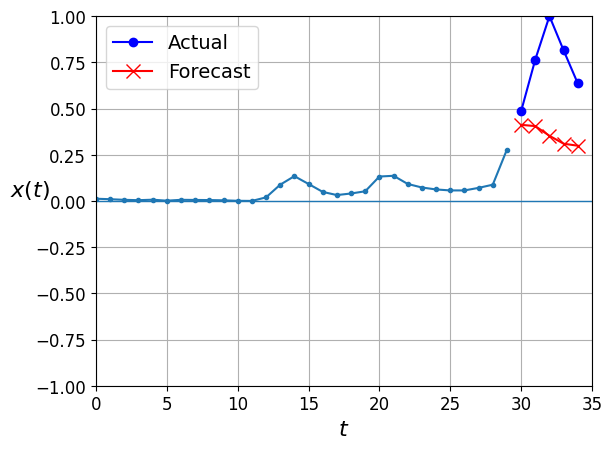

In [37]:
plot_multiple_forecasts(X_test, y_test, RNNpred)
#save_fig("forecast_ahead_plot")
plt.show()

# Red LSTM

Red LSTM que cada 30 días anteriores de entrada, nos predice 1 día de salida 

In [38]:
LSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(output_length)
])

In [39]:
#Compilación de la red
LSTM.compile(loss="mse", optimizer="rmsprop")
#entrenamiento y validación
historyLSTM = LSTM.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
125/125 [==============================] - 7s 31ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 2/20
125/125 [==============================] - 3s 24ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 3/20
125/125 [==============================] - 3s 24ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 4/20
125/125 [==============================] - 3s 25ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 5/20
125/125 [==============================] - 3s 25ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 6/20
125/125 [==============================] - 3s 24ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 7/20
125/125 [==============================] - 3s 24ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 8/20
125/125 [==============================] - 3s 25ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 9/20
125/125 [==============================] - 3s 25ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 10/20
125/125 [==============================] - 3s 25ms/step - loss: 0.0038 - val_lo

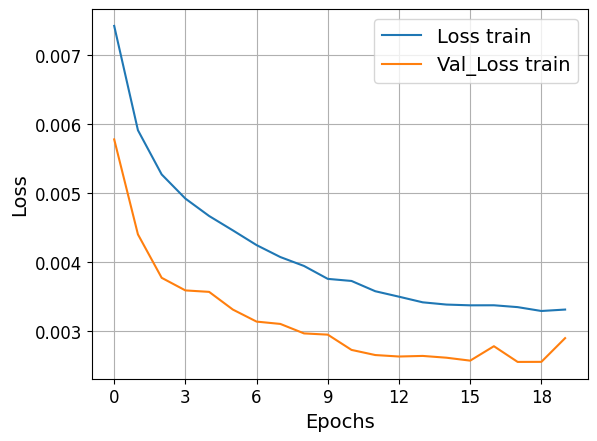

In [40]:
# Graficamos los resultados de modelo 
plt.plot(historyLSTM.history["loss"],label="Loss train")
plt.plot(historyLSTM.history["val_loss"],label="Val_Loss train")
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)      

In [41]:
LSTMpred = LSTM.predict(X_test)

2/2 [==============================] - 1s 6ms/step


In [42]:
LSTMpred = scaler.inverse_transform(LSTMpred)

In [43]:
LSTMpred= pd.DataFrame(LSTMpred)
LSTMpred = LSTMpred.astype(float)


In [44]:
mse_list, rmse_list, mae_list, mape_list= metricas(realidad,LSTMpred)

Predicción día 1
Testing RNN MSE: 15860.0202
Testing RNN RMSE: 125.9366
Testing RNN MAE: 72.1280
Testing RNN MAPE: 0.1993%
Predicción día 2
Testing RNN MSE: 19109.3638
Testing RNN RMSE: 138.2366
Testing RNN MAE: 73.1728
Testing RNN MAPE: 0.2308%
Predicción día 3
Testing RNN MSE: 25539.2062
Testing RNN RMSE: 159.8099
Testing RNN MAE: 83.5662
Testing RNN MAPE: 0.2409%
Predicción día 4
Testing RNN MSE: 30436.4631
Testing RNN RMSE: 174.4605
Testing RNN MAE: 95.6324
Testing RNN MAPE: 0.2936%
Predicción día 5
Testing RNN MSE: 31568.3383
Testing RNN RMSE: 177.6748
Testing RNN MAE: 104.7947
Testing RNN MAPE: 0.3482%


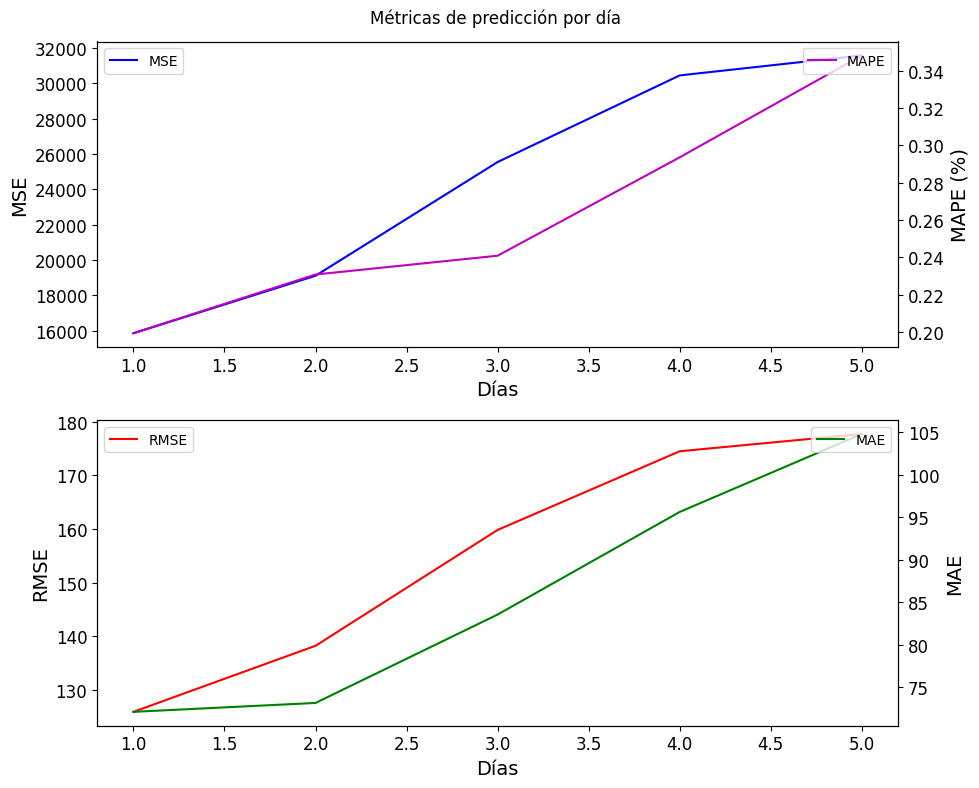

In [45]:
# Graficar las métricas
graficar_metricas(dias, mse_list, rmse_list, mae_list, mape_list)

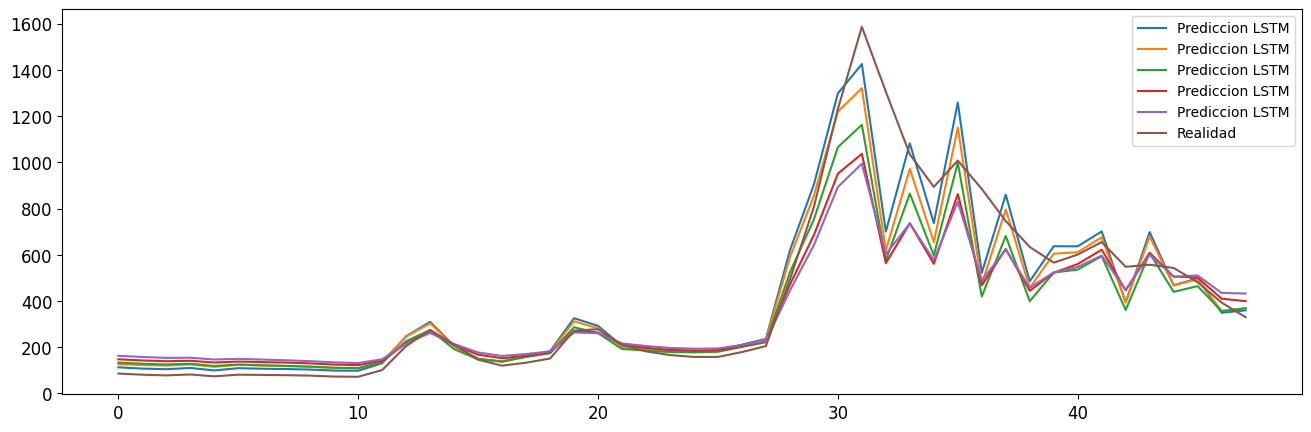

In [46]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(LSTMpred, label="Prediccion LSTM")
ax.plot(realidad , label="Realidad")# cada 30 días, nos predice 1 salida (0 al 29, empezamos en el día 29)
plt.legend();

In [47]:
LSTMpred = LSTM.predict(X_test)

2/2 [==============================] - 0s 7ms/step


In [48]:
LSTMpred  = LSTMpred.reshape(LSTMpred.shape[0],LSTMpred.shape[1],1)

In [49]:
#plot_multiple_forecasts(X_test, y_test, LSTMpred)
#save_fig("forecast_ahead_plot")
#plt.show()

# Red GRU

Red GRU que cada 30 días anteriores de entrada, nos predice 1 día

In [50]:
GRU = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20),
    keras.layers.Dense(output_length)
])

In [51]:
#Compilación de la red
GRU.compile(loss="mse", optimizer="rmsprop")
#entrenamiento y validación
historyGRU = GRU.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
125/125 [==============================] - 8s 36ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 2/20
125/125 [==============================] - 4s 29ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 3/20
125/125 [==============================] - 4s 28ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 4/20
125/125 [==============================] - 3s 26ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 5/20
125/125 [==============================] - 4s 28ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 6/20
125/125 [==============================] - 4s 30ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 7/20
125/125 [==============================] - 4s 30ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 8/20
125/125 [==============================] - 3s 27ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 9/20
125/125 [==============================] - 4s 28ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 10/20
125/125 [==============================] - 4s 30ms/step - loss: 0.0034 - val_lo

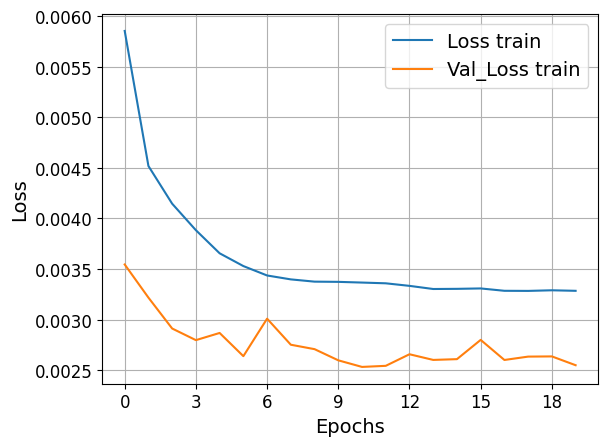

In [52]:
# Graficamos los resultados de modelo 
plt.plot(historyGRU.history["loss"],label="Loss train")
plt.plot(historyGRU.history["val_loss"],label="Val_Loss train")
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)   

In [53]:
GRUpred = GRU.predict(X_test)

2/2 [==============================] - 1s 7ms/step


In [54]:
GRUpred = scaler.inverse_transform(GRUpred)

In [55]:
GRUpred = pd.DataFrame(GRUpred)
GRUpred = GRUpred.astype(float)


In [56]:
mse_list, rmse_list, mae_list, mape_list= metricas(realidad,GRUpred)

Predicción día 1
Testing RNN MSE: 10323.5778
Testing RNN RMSE: 101.6050
Testing RNN MAE: 50.5657
Testing RNN MAPE: 0.0993%
Predicción día 2
Testing RNN MSE: 20776.0078
Testing RNN RMSE: 144.1388
Testing RNN MAE: 64.9383
Testing RNN MAPE: 0.1122%
Predicción día 3
Testing RNN MSE: 23725.1418
Testing RNN RMSE: 154.0297
Testing RNN MAE: 69.3889
Testing RNN MAPE: 0.1178%
Predicción día 4
Testing RNN MSE: 31328.8789
Testing RNN RMSE: 176.9997
Testing RNN MAE: 80.4587
Testing RNN MAPE: 0.1558%
Predicción día 5
Testing RNN MSE: 34233.6604
Testing RNN RMSE: 185.0234
Testing RNN MAE: 91.0206
Testing RNN MAPE: 0.1744%


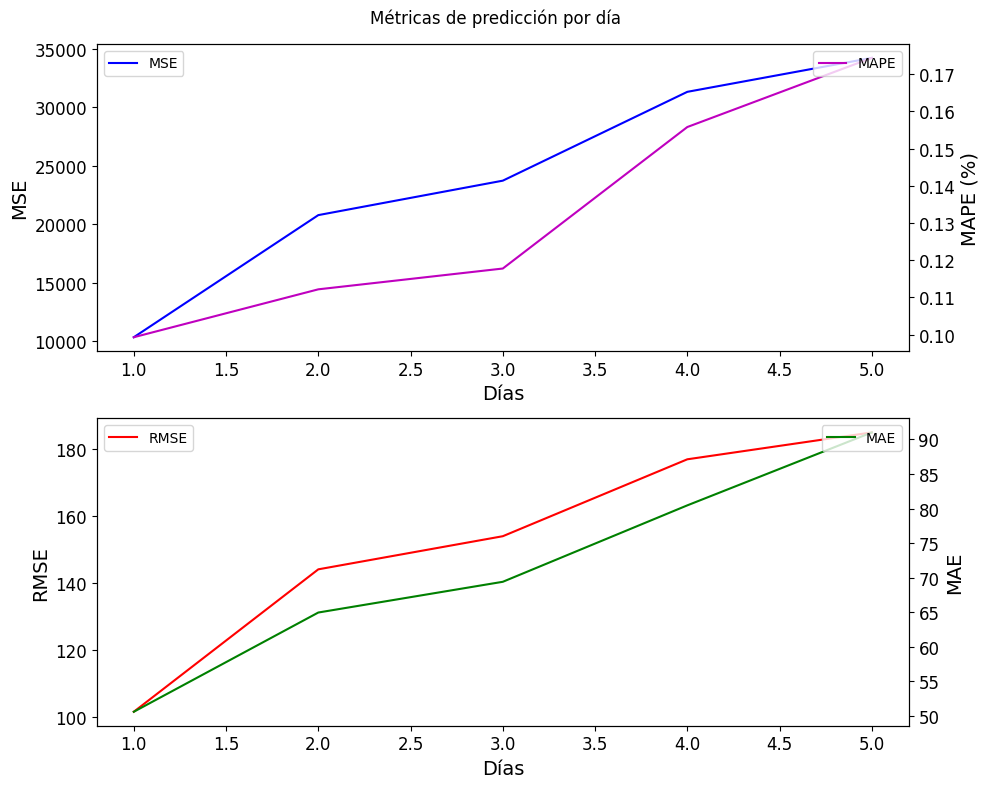

In [57]:
# Graficar las métricas
graficar_metricas(dias, mse_list, rmse_list, mae_list, mape_list)

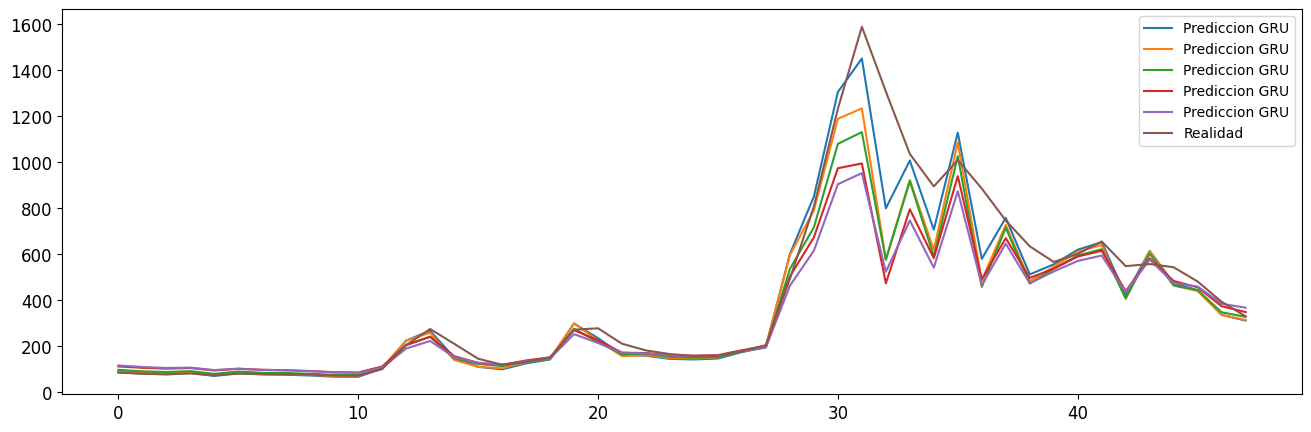

In [58]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(GRUpred, label="Prediccion GRU")
ax.plot(realidad, label="Realidad")# cada 30 días, nos predice 1 salida (0 al 29, empezamos en el día 29)
plt.legend();

In [59]:
GRUpred = GRU.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [60]:
GRUpred  = GRUpred.reshape(GRUpred.shape[0],GRUpred.shape[1],1)

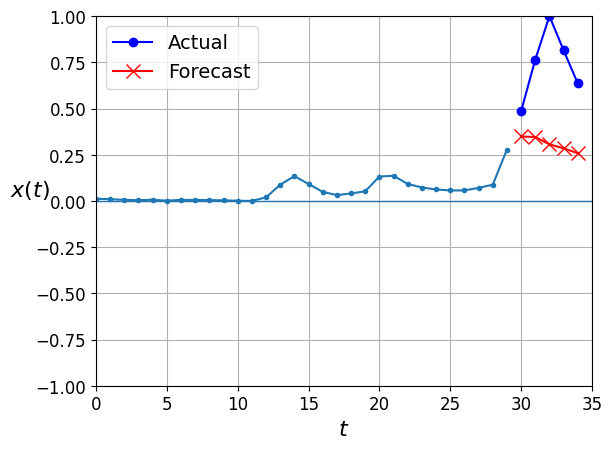

In [61]:
plot_multiple_forecasts(X_test, y_test, GRUpred)
#save_fig("forecast_ahead_plot")
plt.show()

# Comparativa final de los modelos RNN, LSTM y GRU

ValueError: x and y can be no greater than 2D, but have shapes (48,) and (48, 5, 1)

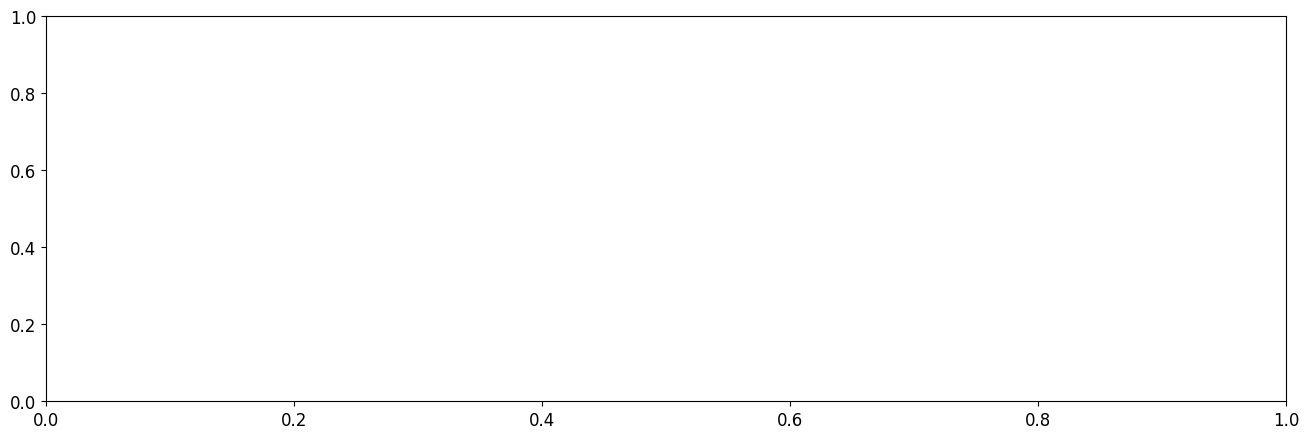

In [62]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(RNNpred, label="Prediccion RNN")
ax.plot(LSTMpred, label="Prediccion LSTM")
ax.plot(GRUpred, label="Prediccion GRU")
ax.plot(realidad, label="Realidad")
plt.legend();